# Water potability example
https://machinelearningmastery.com/building-a-binary-classification-model-in-pytorch/

## Load dataset

In [1]:
import pandas as pd
 
# Read data
data = pd.read_csv("water_potability.csv")
#X = data.loc[:, ['ph', 'Sulfate', 'Conductivity', 'Organic_carbon']]
#y = data.loc[:, ['Potability']]
X = data.iloc[:, 0:9]
y = data.iloc[:, 9]

In [2]:
X.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,0.587349,0.577747,0.386298,0.568199,0.647347,0.292985,0.654522,0.795029,0.630115
1,0.643654,0.441300,0.314381,0.439304,0.514545,0.356685,0.377248,0.202914,0.520358
2,0.388934,0.470876,0.506122,0.524364,0.561537,0.142913,0.249922,0.401487,0.219973
3,0.725820,0.715942,0.506141,0.521683,0.751819,0.148683,0.467200,0.658678,0.242428
4,0.610517,0.532588,0.237701,0.270288,0.495155,0.494792,0.409721,0.469762,0.585049


In [3]:
from sklearn.preprocessing import LabelEncoder
 
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [4]:
encoder.classes_

array([0, 1])

In [5]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [6]:
import torch
 
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

## Create a model

In [7]:
import torch.nn as nn
 
class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(9, 27)
        self.relu = nn.ReLU()
        self.output = nn.Linear(27, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

In [9]:
class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(9, 9)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(9, 9)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(9, 9)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(9, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

## Split data

In [10]:
from sklearn.model_selection import StratifiedKFold, train_test_split
 
# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

## Cross-validation

In [39]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
 
def model_train(model, X_train, y_train, X_val, y_val, loss_fn, optimizer, n_epochs=50): 
    n_epochs = n_epochs   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
 
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None
 
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

Try out params for SGM optimizer

In [59]:
cv_results = pd.DataFrame(columns=["model", "lr", "momentum", "acc", "std"])
# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True)

for lr in range(2, 9):
    lr = lr / 100
    for momentum in range(94, 100, 1):
        momentum = momentum / 100
        cv_scores = []
        for train, test in kfold.split(X_train, y_train):
            # loss function and optimizer
            loss_fn = nn.BCELoss()  # binary cross entropy
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
            # create model, train, and get accuracy
            model = Wide()
            acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test], loss_fn, optimizer, 25)
            cv_scores.append(acc)
        mean_acc = np.mean(cv_scores)
        mean_std = np.std(cv_scores)
        print("Accuracy (lr: %f, momentum: %f): %.2f" % (lr, momentum, acc))
        cv_results = cv_results._append({"model": "wide", "lr": lr, "momentum": momentum, "acc": mean_acc, "std": mean_std}, ignore_index=True)

Accuracy (lr: 0.020000, momentum: 0.940000): 0.60


/tmp/ipykernel_47389/3638243877.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cv_results = cv_results._append({"model": "wide", "lr": lr, "momentum": momentum, "acc": mean_acc, "std": mean_std}, ignore_index=True)


Accuracy (lr: 0.020000, momentum: 0.950000): 0.60
Accuracy (lr: 0.020000, momentum: 0.960000): 0.40
Accuracy (lr: 0.020000, momentum: 0.970000): 0.60
Accuracy (lr: 0.020000, momentum: 0.980000): 0.40
Accuracy (lr: 0.020000, momentum: 0.990000): 0.40
Accuracy (lr: 0.030000, momentum: 0.940000): 0.60
Accuracy (lr: 0.030000, momentum: 0.950000): 0.59
Accuracy (lr: 0.030000, momentum: 0.960000): 0.39
Accuracy (lr: 0.030000, momentum: 0.970000): 0.47
Accuracy (lr: 0.030000, momentum: 0.980000): 0.60
Accuracy (lr: 0.030000, momentum: 0.990000): 0.40
Accuracy (lr: 0.040000, momentum: 0.940000): 0.59
Accuracy (lr: 0.040000, momentum: 0.950000): 0.40
Accuracy (lr: 0.040000, momentum: 0.960000): 0.60
Accuracy (lr: 0.040000, momentum: 0.970000): 0.40
Accuracy (lr: 0.040000, momentum: 0.980000): 0.39
Accuracy (lr: 0.040000, momentum: 0.990000): 0.40
Accuracy (lr: 0.050000, momentum: 0.940000): 0.55
Accuracy (lr: 0.050000, momentum: 0.950000): 0.48
Accuracy (lr: 0.050000, momentum: 0.960000): 0.60


In [60]:
cv_results.sort_values(by='acc', ascending=False, inplace=True)
cv_results.head()

,model,lr,momentum,acc,std
13,wide,0.04,0.95,0.556454,0.070871
7,wide,0.03,0.95,0.549498,0.076045
9,wide,0.03,0.97,0.543592,0.080127
26,wide,0.06,0.96,0.542984,0.087389
22,wide,0.05,0.98,0.538009,0.091662


## Retrain final model

In [61]:
best = cv_results.iloc[0]
# loss function and optimizer
loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.SGD(model.parameters(), lr=best.lr, momentum=best.momentum)
acc = model_train(model, X_train, y_train, X_test, y_test, loss_fn, optimizer, 250)
print(f"Final model accuracy: {acc*100:.2f}%")

Final model accuracy: 59.11%


## Inference
Test inference by running 5 samples from test dataset

In [62]:
model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        y_pred = model(X_test[i:i+1])
        print(f"{X_test[i].numpy()} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")

[0.39241543 0.53410065 0.33871725 0.5672166  0.38731602 0.9182266
 0.54631406 0.5251893  0.40873888] -> [0.35710853] (expected [0.])
[0.4414133  0.604799   0.39342815 0.49100453 0.4402344  0.2705878
 0.71195996 0.46142605 0.6282122 ] -> [0.36561126] (expected [0.])
[0.34953028 0.49078384 0.3030454  0.5497642  0.5485517  0.44013718
 0.61567175 0.5021979  0.61324877] -> [0.36286065] (expected [0.])
[0.6417422  0.37393522 0.35499853 0.5280535  0.498728   0.37569863
 0.32162672 0.65971345 0.5648453 ] -> [0.36583436] (expected [0.])
[0.64345044 0.555361   0.56824684 0.46899134 0.54563564 0.44884896
 0.4158005  0.6986135  0.59073627] -> [0.36937305] (expected [1.])


## ROC
Receiver operating characteristics curve

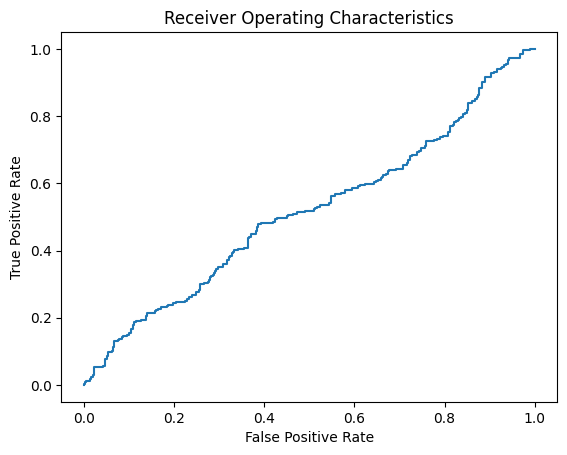

In [63]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
 
with torch.no_grad():
    # Plot the ROC curve
    y_pred = model(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()